In [1]:
from utils import *

# Model selection

In [2]:
# load the data
data_points = pd.read_csv(os.path.join('..', 'data', 'processed', 'points_aggregated_data.csv'), delimiter=';')

In [3]:
# define main mouse movement metric columns
columns = list(filter(lambda x: x not in (useless_columns + filter_columns + ['age', 'dpi', 'sens']), list(data_points.columns)))
data_points = data_points[columns + ['age', 'sens', 'dpi', 'sex', 'respondent_id']]
data_points.age = data_points.age.astype(float)

## Correlations

<Axes: >

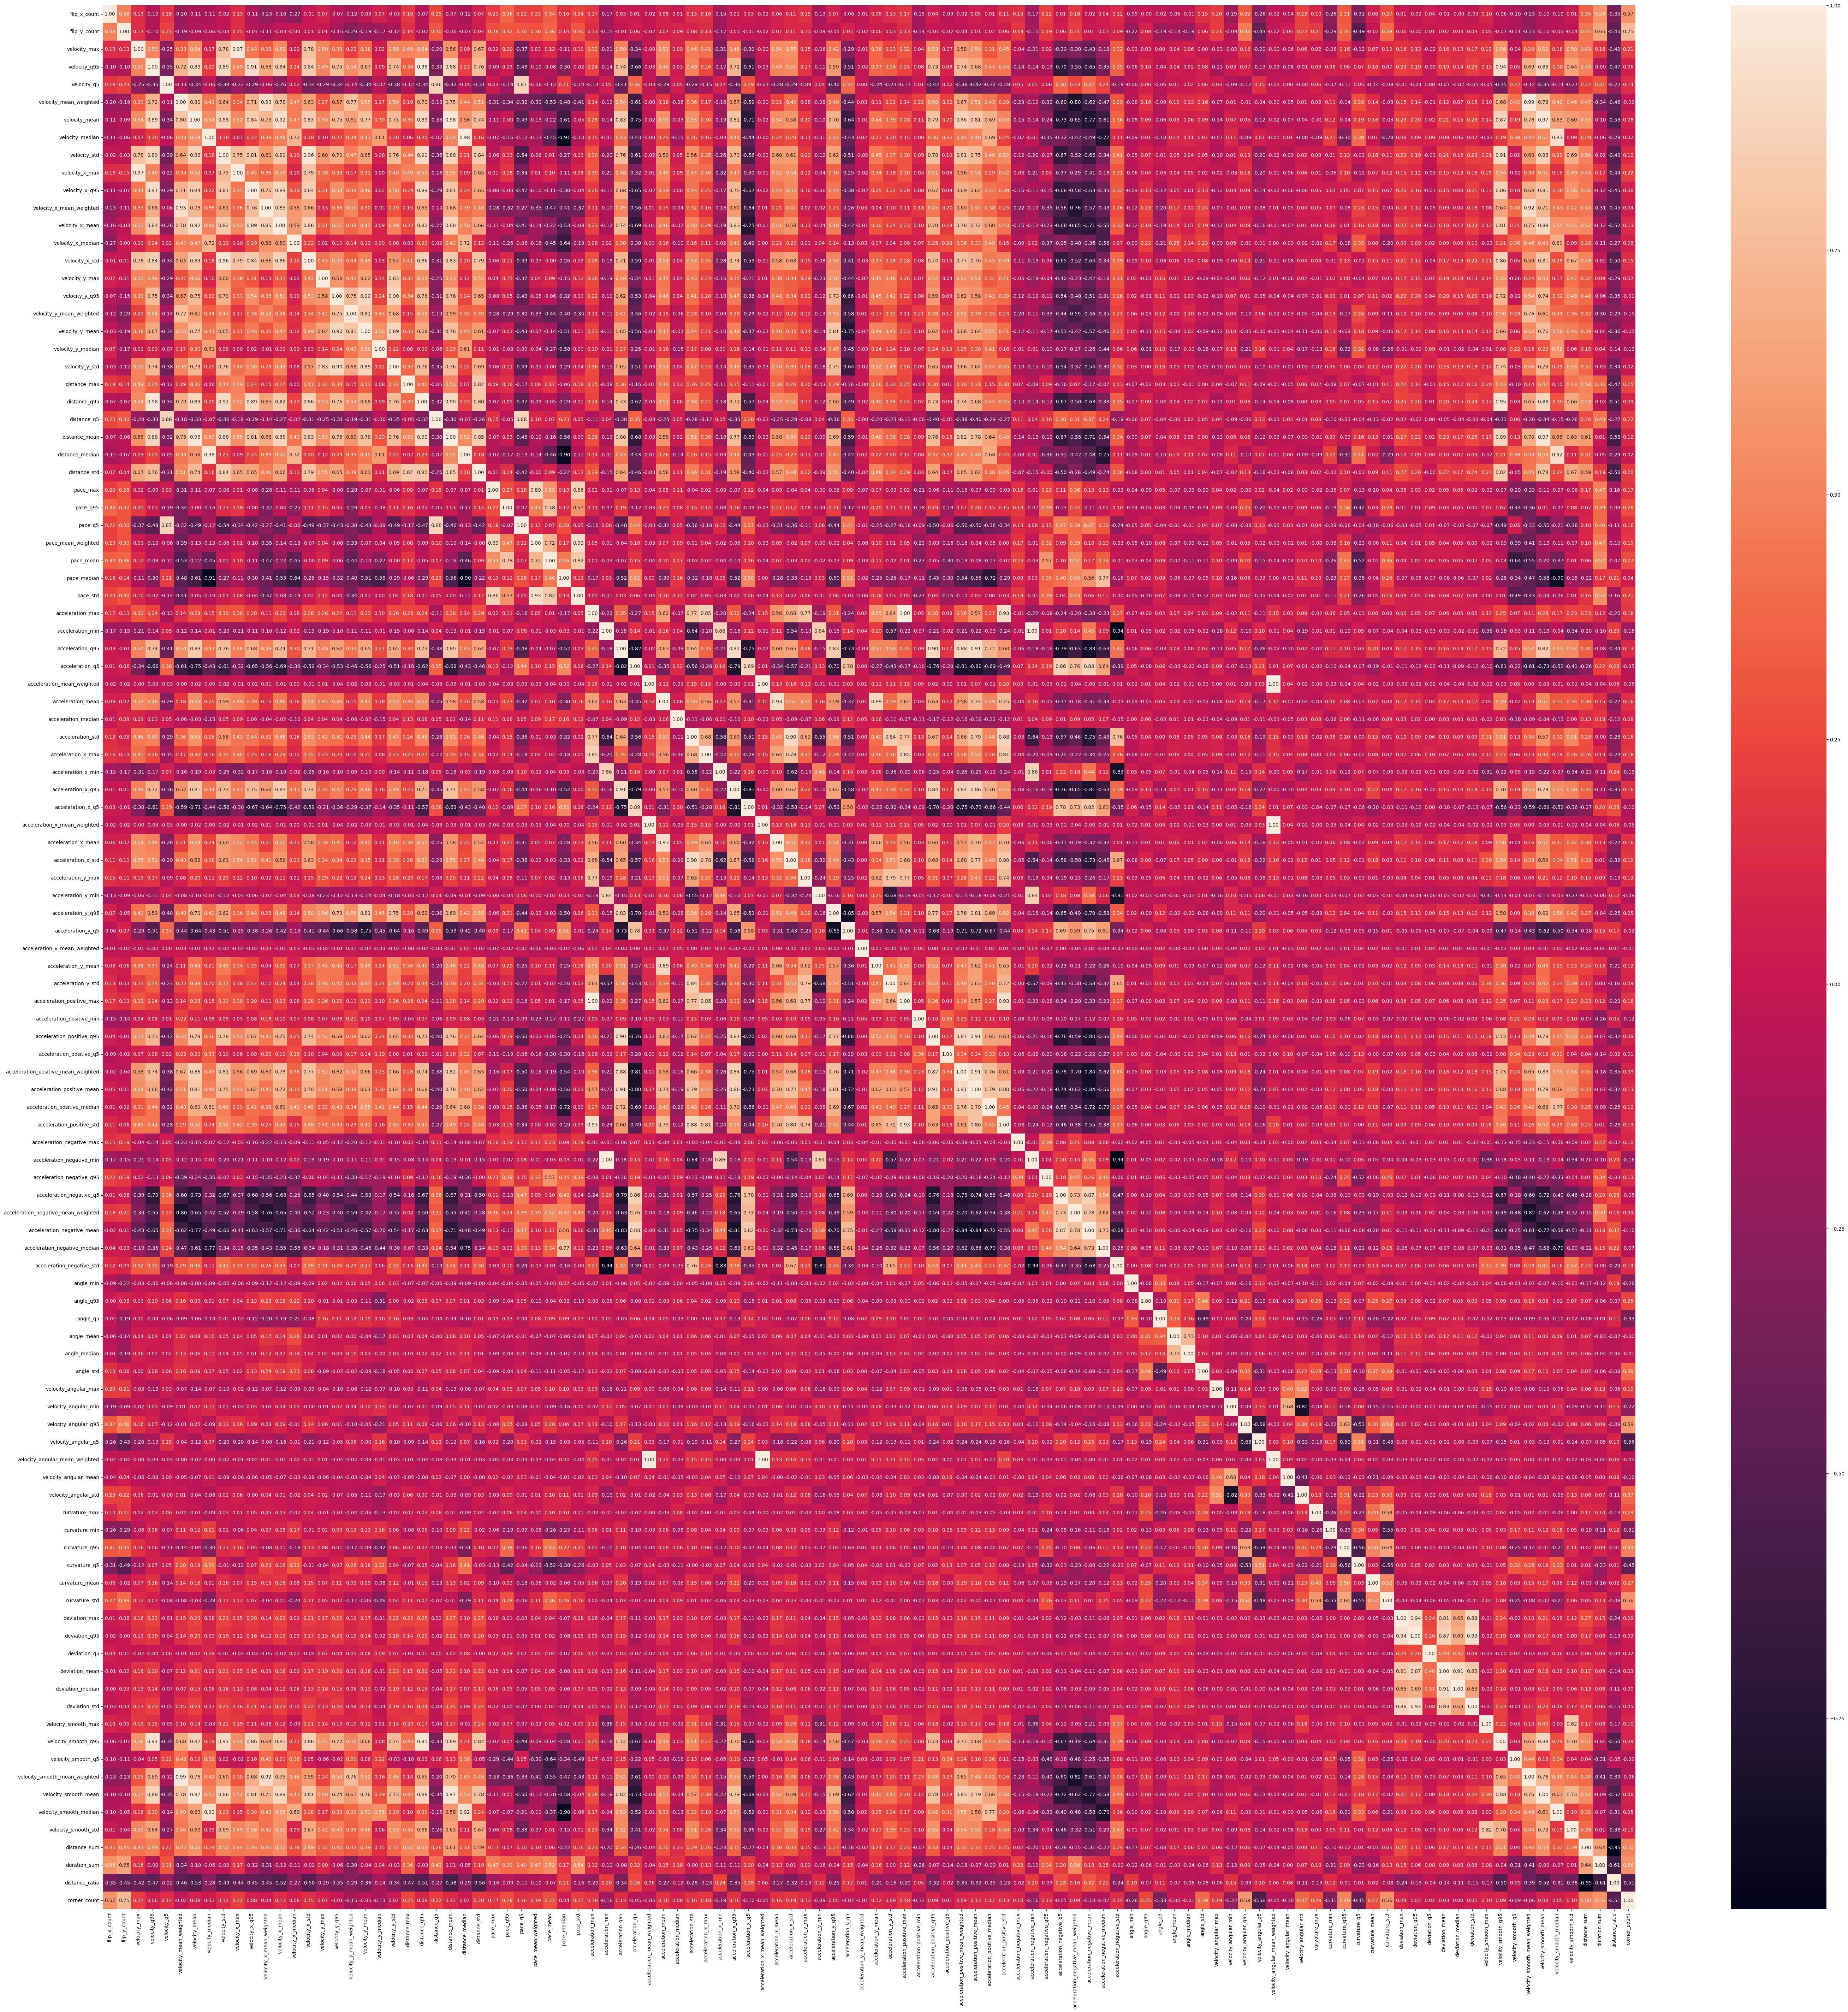

In [4]:
p, ax = plt.subplots(figsize=(70,70))
sns.heatmap(data_points[columns].corr(), ax=ax, annot=True, fmt=".2f")

## Train test split definitions

In [5]:
# random train test split calculation, output data in utils.py file
# train_ids = []
# test_ids = []

# for i in range(10):
#     ids = list(map(lambda x: (x[0][0], x[1][0]), np.unique(np.array(data_points[['respondent_id', 'sex']].values, dtype=[('f2', '<U5')]), axis=0)))
#     random.shuffle(ids)
#     men = list(filter(lambda x: x[1]=='man', ids))
#     women = list(filter(lambda x: x[1]=='woman', ids))
#     tr = men[:12] + women[:12]
#     te = men[12:] + women[12:]
#     random.shuffle(tr)
#     random.shuffle(te)
#     train_ids.append(list(map(lambda x: x[0],tr)))
#     test_ids.append(list(map(lambda x: x[0],te)))

In [6]:
# split data into groups
data_1000_10 = data_points[(data_points.dpi==1000) & (data_points.sens==10)]
data_2400_5 = data_points[(data_points.dpi==2400) & (data_points.sens==5)]
data_2400_18 = data_points[(data_points.dpi==2400) & (data_points.sens==18)]
data_2400_10 = data_points[(data_points.dpi==2400) & (data_points.sens==10)]
data_4800_10 = data_points[(data_points.dpi==4800) & (data_points.sens==10)]

data_low_ecpi = pd.concat([data_2400_5, data_1000_10, data_2400_10])
data_low_ecpi_invert = pd.concat([data_2400_18, data_4800_10])
data_high_ecpi = pd.concat([data_2400_18, data_4800_10, data_2400_10])
data_high_ecpi_invert = pd.concat([data_2400_5, data_1000_10])

In [7]:
# define features from previous tests
features = [
    'curvature_std',
    'acceleration_negative_mean_weighted',
    'curvature_q95',
    'curvature_mean',
    'acceleration_negative_q5',
    'acceleration_x_q5',
    'acceleration_q5',
    'velocity_angular_q95',
    'acceleration_negative_mean',
    'velocity_x_std',
    'velocity_smooth_mean_weighted',
    'velocity_angular_q5',
    'velocity_x_mean_weighted',
    'acceleration_x_q95',
    'velocity_mean_weighted'
]

In [8]:
#prepare pipelines for ordinal and continous data
ordinal_pipe = Pipeline(steps=[
    ('encoder', OrdinalEncoder())
])

continous_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson', standardize=True))
])

preprocessor = ColumnTransformer([
    ('continous', continous_pipe, [i for i in range(len(features))]),
    ('ordinal', ordinal_pipe, [len(features)]),
])

In [9]:
# define datasets used
datasets = {
    # '1000-DPI_10-S' : data_1000_10, 
    # '2400-DPI_5-S' : data_2400_5, 
    # '2400-DPI_10-S' : data_2400_10, 
    # '2400-DPI_18-S' : data_2400_18, 
    # '4800-DPI_10-S' : data_4800_10,
    '123': data_low_ecpi,
    '45': data_low_ecpi_invert,
    '345': data_high_ecpi,
    '12': data_high_ecpi_invert,
    # '2400-DPI_ALL-S': data_sens,
    # 'ALL-DPI_10-S' : data_dpi,
    'ALL' : data_points
}

## Individual configurations comparision

In [10]:
filterwarnings('ignore')

results1 = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC score', 'Trained', 'Tested', 'TrainedN', 'TestedN'])

for index, tr_ids in enumerate(train_ids):
    for dataset in datasets:
        train = datasets[dataset][datasets[dataset]['respondent_id'].isin(tr_ids)]
        processed_train = pd.DataFrame(preprocessor.fit_transform(train[features + ['sex']]), columns=features + ['sex'])
        predictors_train = processed_train.iloc[:, [i for i in range(len(features))]]
        target_train = processed_train.iloc[:, len(features)]

        for model in [
            LogisticRegression(),
            CalibratedClassifierCV(LinearSVC()),
            RandomForestClassifier(),
            XGBClassifier(verbosity=0), 
            LGBMClassifier(),
            CatBoostClassifier(logging_level='Silent')
        ]:
            model.fit(predictors_train, target_train)

            for test_dataset in datasets:
                test = datasets[test_dataset][datasets[test_dataset]['respondent_id'].isin(test_ids[index])]
                test = test.sample(n=95)
                processed_test = pd.DataFrame(preprocessor.fit_transform(test[features + ['sex']]), columns=features + ['sex'])
                predictors_test = processed_test.iloc[:, [i for i in range(len(features))]]
                target_test = processed_test.iloc[:, len(features)]

                report = classification_report(target_test, model.predict(predictors_test), output_dict=True)

                result = pd.DataFrame(data={
                    'Model' : [type(model).__name__],
                    'Accuracy' : [report['accuracy']],
                    'Precision' : [report['macro avg']['precision']],
                    'Recall' : [report['macro avg']['recall']],
                    'F1 score' : [report['macro avg']['f1-score']],
                    'AUC score' : [roc_auc_score(target_test, model.predict_proba(predictors_test)[:,1])],
                    'Trained': [dataset],
                    'Tested': [test_dataset],
                    'TrainedN': [train.shape[0]],
                    'TestedN': [test.shape[0]],
                    'Batch': index
                })
                
                results1 = pd.concat([results1, result])

  File "c:\Users\mkrajcovic\Desktop\mouse-dynamics-data-credibility\analysis\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Number of positive: 216, number of negative: 215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2112
[LightGBM] [Info] Number of data points in the train set: 431, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501160 -> initscore=0.004640
[LightGBM] [Info] Start training from score 0.004640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [34]:
grouped1 = results1.groupby(['Trained', 'Tested', 'Model'], sort=False).mean().round(3).reset_index()
grouped1[((grouped1.Trained=='123') & (grouped1.Tested=='123')) 
        | ((grouped1.Trained=='123') & (grouped1.Tested=='45')) 
        | ((grouped1.Trained=='345') & (grouped1.Tested=='345')) 
        | ((grouped1.Trained=='345') & (grouped1.Tested=='12'))
].sort_values(by='Model', kind='stable')

Trained Tested                   Model  Accuracy  Precision  Recall   
5      123    123  CalibratedClassifierCV     0.614      0.615   0.615  \
6      123     45  CalibratedClassifierCV     0.576      0.576   0.576   
67     345    345  CalibratedClassifierCV     0.612      0.611   0.611   
68     345     12  CalibratedClassifierCV     0.577      0.577   0.577   
25     123    123      CatBoostClassifier     0.553      0.553   0.553   
26     123     45      CatBoostClassifier     0.576      0.578   0.576   
87     345    345      CatBoostClassifier     0.587      0.588   0.587   
88     345     12      CatBoostClassifier     0.574      0.575   0.574   
20     123    123          LGBMClassifier     0.554      0.553   0.552   
21     123     45          LGBMClassifier     0.526      0.526   0.526   
82     345    345          LGBMClassifier     0.568      0.570   0.570   
83     345     12          LGBMClassifier     0.563      0.565   0.563   
0      123    123      LogisticRegression     0.601      0.601   0.601   
1      123     45      LogisticRegression     0.575      0.575   0.575   
62     345    345      LogisticRegression     0.620      0.620   0.620   
63     345     12      LogisticRegression     0.583      0.583   0.583   
10     123    123  RandomForestClassifier     0.562      0.562   0.563   
11     123     45  RandomForestClassifier     0.541      0.541   0.541   
72     345    345  RandomForestClassifier     0.606      0.609   0.607   
73     345     12  RandomForestClassifier     0.572      0.573   0.572   
15     123    123           XGBClassifier     0.562      0.563   0.562   
16     123     45           XGBClassifier     0.547      0.548   0.547   
77     345    345           XGBClassifier     0.586      0.586   0.586   
78     345     12           XGBClassifier     0.571      0.572   0.570   

    F1 score  AUC score TrainedN TestedN  Batch  
5      0.613      0.639  430.300  95.000  4.500  
6      0.575      0.608  430.300  95.000  4.500  
67     0.610      0.643  432.000  95.000  4.500  
68     0.577      0.599  432.000  95.000  4.500  
25     0.550      0.596  430.300  95.000  4.500  
26     0.574      0.605  430.300  95.000  4.500  
87     0.586      0.636  432.000  95.000  4.500  
88     0.572      0.608  432.000  95.000  4.500  
20     0.551      0.576  430.300  95.000  4.500  
21     0.526      0.557  430.300  95.000  4.500  
82     0.567      0.605  432.000  95.000  4.500  
83     0.561      0.572  432.000  95.000  4.500  
0      0.600      0.638  430.300  95.000  4.500  
1      0.574      0.609  430.300  95.000  4.500  
62     0.619      0.646  432.000  95.000  4.500  
63     0.583      0.606  432.000  95.000  4.500  
10     0.560      0.595  430.300  95.000  4.500  
11     0.540      0.576  430.300  95.000  4.500  
72     0.605      0.646  432.000  95.000  4.500  
73     0.569      0.608  432.000  95.000  4.500  
15     0.560      0.580  430.300  95.000  4.500  
16     0.547      0.575  430.300  95.000  4.500  
77     0.585      0.627  432.000  95.000  4.500  
78     0.568      0.567  432.000  95.000  4.500

## Individual configuration cross testing

In [12]:
filterwarnings('ignore')
results2 = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC score', 'Features'])

for index, tr_ids in enumerate(train_ids):
    for cols in [features, features + ['dpi', 'sens']]:

        preprocessor = ColumnTransformer([
            ('continous', continous_pipe, [i for i in range(len(cols))]),
            ('ordinal', ordinal_pipe, [len(cols)]),
        ])

        train = datasets[dataset][datasets[dataset]['respondent_id'].isin(tr_ids)]
        processed_train = pd.DataFrame(preprocessor.fit_transform(train[cols + ['sex']]), columns=cols + ['sex'])
        predictors_train = processed_train.iloc[:, [i for i in range(len(cols))]]
        target_train = processed_train.iloc[:, len(cols)]

        test = datasets[test_dataset][datasets[test_dataset]['respondent_id'].isin(test_ids[index])]
        processed_test = pd.DataFrame(preprocessor.fit_transform(test[cols + ['sex']]), columns=cols + ['sex'])
        predictors_test = processed_test.iloc[:, [i for i in range(len(cols))]]
        target_test = processed_test.iloc[:, len(cols)]

        for model in [
            LogisticRegression(),
            CalibratedClassifierCV(LinearSVC()),
            RandomForestClassifier(),
            XGBClassifier(verbosity=0), 
            LGBMClassifier(),
            CatBoostClassifier(logging_level='Silent')
        ]:
            model.fit(predictors_train, target_train)

            report = classification_report(target_test, model.predict(predictors_test), output_dict=True)

            result = pd.DataFrame(data={
                'Model' : [type(model).__name__],
                'Accuracy' : [report['accuracy']],
                'Precision' : [report['macro avg']['precision']],
                'Recall' : [report['macro avg']['recall']],
                'F1 score' : [report['macro avg']['f1-score']],
                'AUC score' : [roc_auc_score(target_test, model.predict_proba(predictors_test)[:,1])],
                'Features': [len(cols)],
                'Batch': index
            })
            
            results2 = pd.concat([results2, result])
                

[LightGBM] [Info] Number of positive: 360, number of negative: 359
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3600
[LightGBM] [Info] Number of data points in the train set: 719, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500695 -> initscore=0.002782
[LightGBM] [Info] Start training from score 0.002782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [36]:
pd.options.display.float_format = '{:.3f}'.format
grouped2 = results2.groupby(['Features', 'Model']).mean().round(3).reset_index()
grouped2.sort_values(by='Model', kind='stable')

Features                   Model  Accuracy  Precision  Recall  F1 score   
0         15  CalibratedClassifierCV     0.534      0.536   0.535     0.533  \
6         17  CalibratedClassifierCV     0.529      0.531   0.529     0.526   
1         15      CatBoostClassifier     0.587      0.588   0.587     0.587   
7         17      CatBoostClassifier     0.590      0.591   0.590     0.589   
2         15          LGBMClassifier     0.584      0.584   0.584     0.583   
8         17          LGBMClassifier     0.571      0.571   0.571     0.570   
3         15      LogisticRegression     0.608      0.608   0.608     0.608   
9         17      LogisticRegression     0.606      0.606   0.606     0.606   
4         15  RandomForestClassifier     0.591      0.592   0.591     0.591   
10        17  RandomForestClassifier     0.587      0.587   0.587     0.586   
5         15           XGBClassifier     0.567      0.567   0.566     0.566   
11        17           XGBClassifier     0.585      0.586   0.585     0.584   

    AUC score  Batch  
0       0.554  4.500  
6       0.546  4.500  
1       0.635  4.500  
7       0.635  4.500  
2       0.614  4.500  
8       0.605  4.500  
3       0.643  4.500  
9       0.641  4.500  
4       0.627  4.500  
10      0.628  4.500  
5       0.601  4.500  
11      0.607  4.500